## Geneformer Fine-Tuning for Cell Annotation Application

In [2]:
import os
import sys
sys.path.append('/home/amonell/Geneformer')
GPU_NUMBER = [0]
os.environ["CUDA_VISIBLE_DEVICES"] = ",".join([str(s) for s in GPU_NUMBER])
os.environ["NCCL_DEBUG"] = "INFO"

In [3]:
import torch

if torch.cuda.is_available():
    print("CUDA is available")
else:
    print("CUDA is not available")

CUDA is available


In [4]:
# imports
from collections import Counter
from tqdm.notebook import tqdm
import datetime
import pickle
import subprocess
import seaborn as sns; sns.set()
from datasets import load_from_disk
from sklearn.metrics import accuracy_score, f1_score
from transformers import BertForSequenceClassification
from transformers import Trainer
from transformers.training_args import TrainingArguments

from geneformer import DataCollatorForCellClassification

/home/amonell/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/amonell/mambaforge/envs/geneformer/lib/python3.10/site-packages/loompy/bus_file.py:68: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def twobit_to_dna(twobit: int, size: int) -> str:
/home/amonell/mambaforge/envs/geneformer/lib/python3.10/site-packages/loompy/bus_file.py:85: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argum

## Prepare training and evaluation datasets

In [5]:
# load train dataset (includes all tissues)
train_dataset=load_from_disk(r"/mnt/sata1/Analysis_Alex/Geneformer/loom_xenium/tokenized/train_xenium.dataset")

In [6]:
# we just want to evaluate on our trainset for now
eval_dataset=train_dataset

In [7]:
dataset_list = []
evalset_list = []
organ_list = []
target_dict_list = []


for organ in Counter(train_dataset["organ_major"]).keys():
    # collect list of tissues for fine-tuning
    if organ in ["bone_marrow"]:
        continue
    elif organ == "immune":
        organ_ids = ["immune", "bone_marrow"]
        organ_list += ["immune"]
    else:
        organ_ids = [organ]
        organ_list += [organ]

    def if_organ(example, organ_id):
        return example["organ_major"] in organ_id

    trainset_organ = train_dataset.filter(function= if_organ, fn_kwargs={'organ_id': organ_ids}, num_proc=16)


    # per scDeepsort published method, drop cell types representing <0.5% of cells
    celltype_counter = Counter(trainset_organ["cell_type"])
    total_cells = sum(celltype_counter.values())
    cells_to_keep = [k for k,v in celltype_counter.items()]
    def if_not_rare_celltype(example, cells_to_keep):
        return example["cell_type"] in cells_to_keep
    trainset_organ_subset = trainset_organ.filter(if_not_rare_celltype, fn_kwargs={'cells_to_keep': cells_to_keep}, num_proc=16)
      
    # shuffle datasets and rename columns
    trainset_organ_shuffled = trainset_organ_subset.shuffle(seed=42)
    trainset_organ_shuffled = trainset_organ_shuffled.rename_column("cell_type","label")
    trainset_organ_shuffled = trainset_organ_shuffled.remove_columns("organ_major")
    
    # create dictionary of cell types : label ids
    target_names = list(Counter(trainset_organ_shuffled["label"]).keys())
    target_name_id_dict = dict(zip(target_names,[i for i in range(len(target_names))]))
    target_dict_list += [target_name_id_dict]
    
    # change labels to numerical ids
    def classes_to_ids(example, target_name_id_dict):
        example["label"] = target_name_id_dict[example["label"]]
        return example
    labeled_trainset = trainset_organ_shuffled.map(classes_to_ids, fn_kwargs={'target_name_id_dict': target_name_id_dict}, num_proc=16)
    
    # create 95/5 train/eval splits
    labeled_train_split = labeled_trainset.select([i for i in range(0,round(len(labeled_trainset)*0.95))])
    labeled_eval_split = labeled_trainset.select([i for i in range(round(len(labeled_trainset)*0.95),len(labeled_trainset))])
    
    # filter dataset for cell types in corresponding training set
    trained_labels = list(Counter(labeled_train_split["label"]).keys())
    def if_trained_label(example, trained_labels):
        return example["label"] in trained_labels
    labeled_eval_split_subset = labeled_eval_split.filter(if_trained_label, fn_kwargs={'trained_labels': trained_labels}, num_proc=16)

    dataset_list += [labeled_train_split]
    evalset_list += [labeled_eval_split_subset]

Filter (num_proc=16): 100%|██████████| 88179/88179 [00:00<00:00, 317783.01 examples/s]


In [8]:
trainset_dict = dict(zip(organ_list,dataset_list))
traintargetdict_dict = dict(zip(organ_list,target_dict_list))

evalset_dict = dict(zip(organ_list,evalset_list))

## Fine-Tune With Cell Classification Learning Objective and Quantify Predictive Performance

In [9]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    # calculate accuracy and macro f1 using sklearn's function
    acc = accuracy_score(labels, preds)
    macro_f1 = f1_score(labels, preds, average='macro')
    return {
      'accuracy': acc,
      'macro_f1': macro_f1
    }

In [10]:
# set model parameters
# max input size
max_input_size = 2 ** 11  # 2048

# set training parameters
# max learning rate
max_lr = 5e-5
# how many pretrained layers to freeze
freeze_layers = 0
# number gpus
num_gpus = 1
# number cpu cores
num_proc = 16
# batch size for training and eval
geneformer_batch_size = 15
# learning schedule
lr_schedule_fn = "linear"
# warmup steps
warmup_steps = 500
# number of epochs
epochs = 3
# optimizer
optimizer = "adamw"

In [11]:
for organ in organ_list:
    print(organ)
    organ_trainset = trainset_dict[organ]
    organ_evalset = evalset_dict[organ]
    organ_label_dict = traintargetdict_dict[organ]
    
    # set logging steps
    logging_steps =1
    
    # reload pretrained model
    model = BertForSequenceClassification.from_pretrained("/mnt/sata1/Analysis_Alex/Geneformer", 
                                                      num_labels=len(organ_label_dict.keys()),
                                                      output_attentions = False,
                                                      output_hidden_states = False).to("cuda")
    
    # define output directory path
    current_date = datetime.datetime.now()
    datestamp = f"{str(current_date.year)[-2:]}{current_date.month:02d}{current_date.day:02d}"
    output_dir = f"/mnt/sata1/Analysis_Alex/Geneformer/{datestamp}_geneformer_CellClassifier_SI2_{organ}_L{max_input_size}_B{geneformer_batch_size}_LR{max_lr}_LS{lr_schedule_fn}_WU{warmup_steps}_E{epochs}_O{optimizer}_F{freeze_layers}/"
    
    # ensure not overwriting previously saved model
    saved_model_test = os.path.join(output_dir, f"pytorch_model.bin")
    if os.path.isfile(saved_model_test) == True:
        raise Exception("Model already saved to this directory.")

    # make output directory
    subprocess.call(f'mkdir {output_dir}', shell=True)
    
    # set training arguments
    training_args = {
        "learning_rate": max_lr,
        "do_train": True,
        "do_eval": True,
        "evaluation_strategy": "epoch",
        "save_strategy": "epoch",
        "logging_steps": logging_steps,
        "group_by_length": True,
        "length_column_name": "length",
        "disable_tqdm": False,
        "lr_scheduler_type": lr_schedule_fn,
        "warmup_steps": warmup_steps,
        "weight_decay": 0.001,
        "per_device_train_batch_size": geneformer_batch_size,
        "per_device_eval_batch_size": geneformer_batch_size,
        "num_train_epochs": epochs,
        "load_best_model_at_end": True,
        "output_dir": output_dir,
    }
    
    training_args_init = TrainingArguments(**training_args)

    # create the trainer
    trainer = Trainer(
        model=model,
        args=training_args_init,
        data_collator=DataCollatorForCellClassification(),
        train_dataset=organ_trainset,
        eval_dataset=organ_evalset,
        compute_metrics=compute_metrics
    )
    # train the cell type classifier
    trainer.train()
    predictions = trainer.predict(organ_evalset)
    with open(f"{output_dir}predictions.pickle", "wb") as fp:
        pickle.dump(predictions, fp)
    trainer.save_metrics("eval",predictions.metrics)
    trainer.save_model(output_dir)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /mnt/sata1/Analysis_Alex/Geneformer and are newly initialized: ['classifier.weight', 'classifier.bias', 'bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


SI


mkdir: cannot create directory ‘/mnt/sata1/Analysis_Alex/Geneformer/231126_geneformer_CellClassifier_SI2_SI_L2048_B15_LR5e-05_LSlinear_WU500_E3_Oadamw_F0/’: File exists
/home/amonell/mambaforge/envs/geneformer/lib/python3.10/site-packages/geneformer/collator_for_classification.py:581: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = {k: torch.tensor(v, dtype=torch.int64) for k, v in batch.items()}


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,0.058400,0.375726,0.861033,0.759840
2,0.886400,0.330439,0.876637,0.803517
3,0.629900,0.313092,0.882512,0.813523


/home/amonell/mambaforge/envs/geneformer/lib/python3.10/site-packages/geneformer/collator_for_classification.py:581: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = {k: torch.tensor(v, dtype=torch.int64) for k, v in batch.items()}
/home/amonell/mambaforge/envs/geneformer/lib/python3.10/site-packages/geneformer/collator_for_classification.py:581: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = {k: torch.tensor(v, dtype=torch.int64) for k, v in batch.items()}
/home/amonell/mambaforge/envs/geneformer/lib/python3.10/site-packages/geneformer/collator_for_classification.py:581: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or s

### Predicting with geneformer and saving predictions

In [13]:
import numpy as np
import scanpy as sc
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt

for filename in glob.glob('/mnt/sata1/Analysis_Alex/timecourse_replicates/day*'):
    outname = os.path.basename(filename)
    # load train dataset (includes all tissues)
    train_dataset='/mnt/sata1/Analysis_Alex/Geneformer/loom_'+outname+'/tokenized/train_'+outname+'.dataset'
    # load evaluation dataset (includes all tissues)
    c = 0
    d = train_dataset
    # load test
    test_dataset=load_from_disk(d)
    test_dataset=test_dataset.add_column('label', [0 for i in range(test_dataset.num_rows)])
    predictions_test=trainer.predict(test_dataset)

    ad=sc.read(os.path.join('/mnt/sata1/Analysis_Alex/timecourse_replicates',outname,'adatas/06_reference_mapped.h5ad'))
    ad.obs['celltype_predicted'] = np.array(target_names)[np.argmax(predictions_test.predictions, axis=1)]
    ad.write(os.path.join('/mnt/sata1/Analysis_Alex/timecourse_replicates',outname,'adatas/07_geneformer_celltypes.h5ad'))
# np.save(f'C:/Users/amonell/Downloads/dset_{c}.npy',np.array(target_names)[np.argmax(predictions_test.predictions, axis=1)])
#     c += 1




/home/amonell/mambaforge/envs/geneformer/lib/python3.10/site-packages/geneformer/collator_for_classification.py:581: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = {k: torch.tensor(v, dtype=torch.int64) for k, v in batch.items()}


/home/amonell/.local/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/amonell/mambaforge/envs/geneformer/lib/python3.10/site-packages/geneformer/collator_for_classification.py:581: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = {k: torch.tensor(v, dtype=torch.int64) for k, v in batch.items()}


/home/amonell/.local/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/amonell/mambaforge/envs/geneformer/lib/python3.10/site-packages/geneformer/collator_for_classification.py:581: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = {k: torch.tensor(v, dtype=torch.int64) for k, v in batch.items()}


/home/amonell/.local/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/amonell/mambaforge/envs/geneformer/lib/python3.10/site-packages/geneformer/collator_for_classification.py:581: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = {k: torch.tensor(v, dtype=torch.int64) for k, v in batch.items()}


/home/amonell/.local/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


Overall Accuracy: 89.15%
Percentage of Correct Predictions per Group:
celltype_predicted
B-Cell                   83.202641
Cd4_T-Cell               83.272805
Cd8_T-Cell_P14           92.508209
Cd8_T-Cell_aa+           90.292364
Cd8_T-Cell_ab+           89.646772
Complement_Fibroblast    84.153005
Contaminated DCs         10.169492
DC2                      76.451954
Early_Enterocyte         90.959178
Enterocyte_1             90.464933
Enterocyte_2             76.432138
Enterocyte_3             90.542563
Enteroendocrine          86.704225
Fibroblast               85.875513
Fibroblast_Ncam1         60.375494
Fibroblast_Pdgfra+       83.360390
Fibroblast_Pdgfrb+       76.253444
Goblet                   80.069808
ILC                      88.700791
ISC                      80.141844
Lymphatic                93.878299
MAIT                     86.925702
Macrophage               88.913999
MegakaryocytePlatelet    59.523810
Monocyte                 84.148185
Myofibroblast            92.935839
N

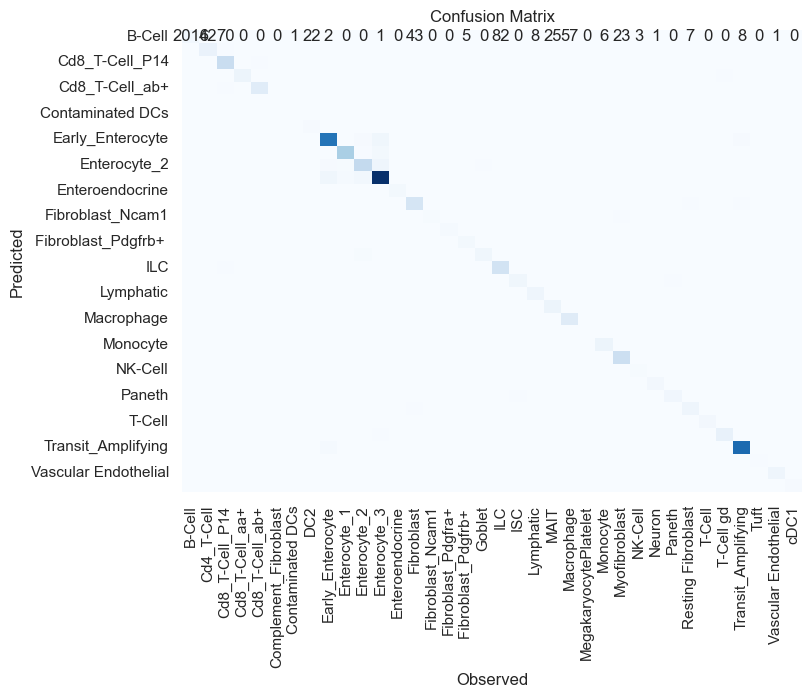

In [62]:

# confusion_matrix = pd.crosstab(ad.obs['Subtype'], ad.obs['celltype_predicted'])

# confusion_matrix = confusion_matrix.loc[confusion_matrix.columns]
# # Calculate the total number of correct predictions
# correct_predictions = confusion_matrix.values.diagonal().sum()

# # Calculate the total number of predictions
# total_predictions = confusion_matrix.values.sum()

# # Calculate the overall accuracy
# accuracy = correct_predictions / total_predictions

# # Calculate the percentage of correct predictions per group
# percentage_correct_per_group = (confusion_matrix.values.diagonal() / confusion_matrix.sum(axis=1)) * 100

# # Print results
# print(f"Overall Accuracy: {accuracy * 100:.2f}%")
# print("Percentage of Correct Predictions per Group:")
# print(percentage_correct_per_group)

# # Plot the heatmap
# plt.figure(figsize=(8, 6))
# sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g', cbar=False)
# plt.xlabel('Observed')
# plt.ylabel('Predicted')
# plt.title('Confusion Matrix')
# plt.show()

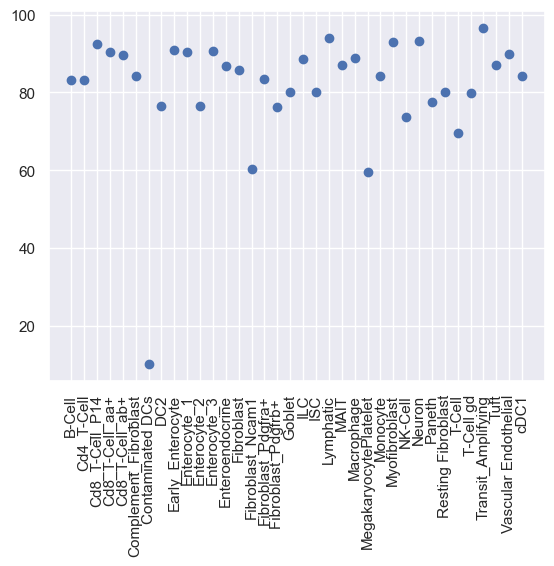

In [71]:
# plt.scatter([i for i in range(len(percentage_correct_per_group.values))], percentage_correct_per_group.values)
# plt.xticks([i for i in range(len(percentage_correct_per_group.values))], percentage_correct_per_group.index.values, rotation=90)
# plt.show()